# ARIMA Time Series Forecasting
Author: Nico Kuijpers  
Date: April 5, 2021

## Introduction
This Jupyter Notebook is adapted from the tutorial *A Guide to Time Series Forecasting with ARIMA in Python 3*, see https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

Time series provide the opportunity to forecast future values. Based on previous values, time series can be used to forecast trends in economics, weather, and capacity planning, to name a few. The specific properties of time-series data mean that specialized statistical methods are usually required.

In this tutorial, we will aim to produce reliable forecasts of time series. We will begin by introducing and discussing the concepts of autocorrelation, stationarity, and seasonality, and proceed to apply one of the most commonly used method for time-series forecasting, known as **ARIMA**.

An ARIMA model is a class of statistical model for analyzing and forecasting time series data.
**ARIMA** is an acronym that stands for **AutoRegressive Integrated Moving Average**. It is a generalization of the simpler **AutoRegressive Moving Average** and adds the notion of integration.
This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:
* **AR: Autoregression**. A model that uses the dependent relationship between an observation and some number of lagged observations.
* **I: Integrated**. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* **MA: Moving Average**. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter.
A standard notation is used of `ARIMA(p,d,q)` where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.
The parameters of the ARIMA model are defined as follows:
* `p`: The number of lag observations included in the model, also called the lag order.
* `d`: The number of times that the raw observations are differenced, also called the degree of differencing.
* `q`: The size of the moving average window, also called the order of moving average.

One of the methods available in Python to model and predict future points of a time series is known as **SARIMAX**, which stands for **Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors**. Here, we will primarily focus on the ARIMA component, which is used to fit time-series data to better understand and forecast future points in the time series.

First import the libraries we need.

In [1]:
import numpy as np
import pandas as pd
import warnings
import itertools
import statsmodels
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt

print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('statsmodels version:', statsmodels.__version__)
print('matplotlib version:', matplotlib.__version__)

%matplotlib inline

numpy version: 1.16.2
pandas version: 0.24.2
statsmodels version: 0.9.0
matplotlib version: 3.0.3


## The Time Series Forecasting steps: overview

This notebook implements all specific tasks for time series forecasting using ARIMA:

* Preparing the data, 
* Analysing and visualising the data, 
* Cleaning the data, 
* The ARIMA Time Series Model,
* Parameter Selection for the ARIMA Time Series Model,
* Fitting an ARIMA Time Series Model, 
* Validating Forecasts, 
* Producing and Visualizing Forecasts.


## Step 1: Preparing the data
To illustrate ARIMA we use a dataset called *"Atmospheric CO<sub>2</sub> from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.,”* which collected CO<sub>2</sub> samples from March 1958 to December 2001. The CO<sub>2</sub> levels are in parts per million per volume (ppmv), which is commonly used for air pollutant concentrations (see, e.g., https://en.wikipedia.org/wiki/Air_pollutant_concentrations)

For more information on the CO<sub>2</sub> dataset, see https://www.statsmodels.org/dev/datasets/generated/co2.html

### Download the dataset

In [2]:
# Download the CO2 dataset
# The code below results in an error message and has been replaced with the code thereafter
#data = sm.datasets.co2.load_pandas()
#y = data.data

# https://stackoverflow.com/questions/55421640/how-to-load-a-statsmodels-dataset-in-python

# load data into pandas DataFrame
df_co2 = pd.DataFrame(sm.datasets.co2.load().data)

# convert bytes into string and then datetime
df_co2['date'] = pd.to_datetime(df_co2.date.apply(lambda x: x.decode("utf-8")))

# set the date as index
df_co2.set_index('date',inplace=True)

### Explore the dataset
Get a first impression of the dataset by printing the data format and showing the first 5 rows and last 5 rows
of the DataFrame.

In [3]:
df_co2.head(5)

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [4]:
df_co2.tail(5)

,co2
date,
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3
2001-12-29,371.5


Method `pandas.DataFrame.info()` prints information about a DataFrame including the index dtype and columns, non-null values, and memory usage. See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html.

In [5]:
df_co2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Data columns (total 1 columns):
co2    2225 non-null float64
dtypes: float64(1)
memory usage: 35.7 KB


Method `pandas.DataFrame.describe()` generates descriptive statistics. These include central tendency, dispersion,
and shape of a dataset's distribution, excluding NaN values. 
See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe

In [6]:
df_co2.describe()

,co2
count,2225.000000
mean,340.142247
std,17.003885
min,313.000000
25%,324.800000
50%,338.300000
75%,354.800000
max,373.900000


### Indexing with Time-series data

You may have noticed that the dates have been set as the index of our pandas DataFrame. When working with time-series data in Python we should ensure that dates are used as an index, so make sure to always check for that, which we can do by running the following:

In [7]:
df_co2.index

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', name='date', length=2284, freq=None)

The `dtype=datetime[ns]` field confirms that our index is made of date stamp objects, while `length=2284` and `freq='W-SAT'` tells us that we have 2,284 weekly date stamps starting on Saturdays.

## Step 2: Analysing and visualising the data

Plot the CO<sub>2</sub> levels versus date.

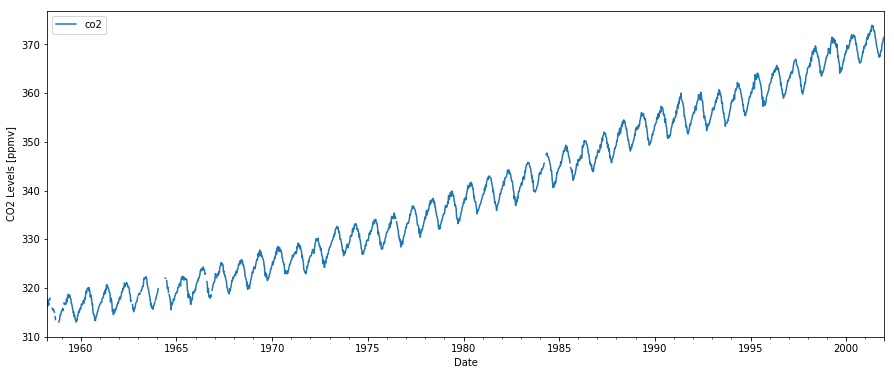

In [8]:
ax = df_co2.plot(figsize=(15, 6))
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels [ppmv]')
plt.show()

It can be observed that there is a gradual increase of CO<sub>2</sub> levels over time and there seems to be some seasonal variation in the data. Also, it can be observed that some values are missing and that there is
some variation on week-to-week basis.

To get more insight in the seasonal variaty, plot the CO<sub>2</sub> values for 1980 through 1982.

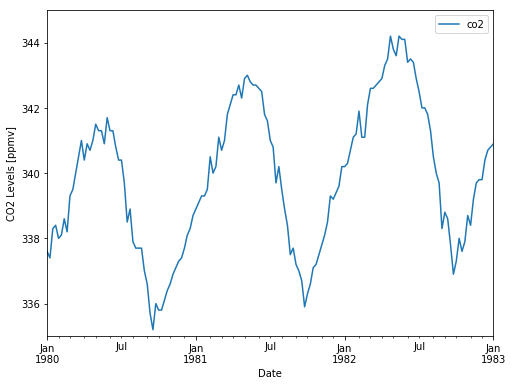

In [9]:
ax = df_co2.plot(figsize=(8, 6))
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels [ppmv]')
plt.xlim(['1980-01-01','1983-01-01'])
plt.ylim([335,345])
plt.show()

## Step 3: Cleaning the data
Let’s preprocess our data a little bit before moving forward. Weekly data can be tricky to work with since it’s a briefer amount of time, so let’s use monthly averages instead. We’ll make the conversion with the resample function. For simplicity, we can also use the `fillna()` function to ensure that we have no missing values in our time series.

In [10]:
# The 'MS' string groups the data in buckets by start of the month
df_co2 = df_co2['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
df_co2 = df_co2.fillna(df_co2.bfill())

print(df_co2)

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
1959-11-01    314.875000
1959-12-01    315.525000
1960-01-01    316.380000
1960-02-01    316.975000
1960-03-01    317.575000
1960-04-01    319.120000
1960-05-01    319.925000
1960-06-01    319.450000
1960-07-01    318.060000
1960-08-01    315.775000
                 ...    
1999-07-01    369.000000
1999-08-01    366.700000
1999-09-01    364.675000
1999-10-01    365.140000
1999-11-01    366.650000
1999-12-01    367.900000
2000-01-01    369.020000
2000-02-01    369.375000
2000-03-01    370.40

Let’s explore this time series e as a data visualization:

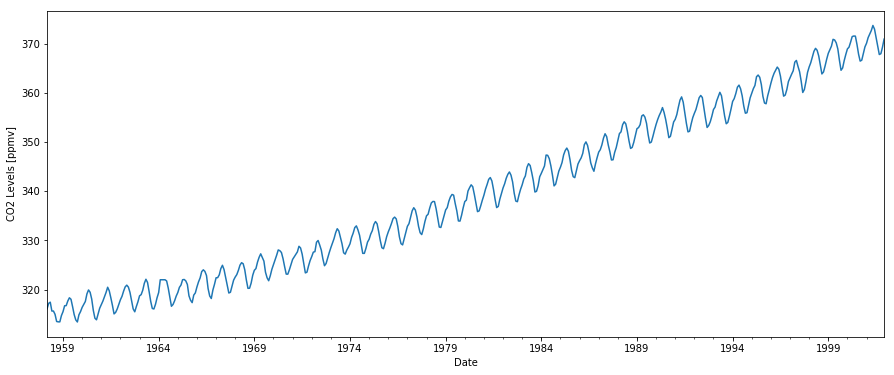

In [11]:
ax = df_co2.plot(figsize=(15, 6))
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels [ppmv]')
plt.show()

Some distinguishable patterns appear when we plot the data. The time series has an obvious seasonality pattern, as well as an overall increasing trend.

As before, we plot the CO<sub>2</sub> values for 1980 through 1982.

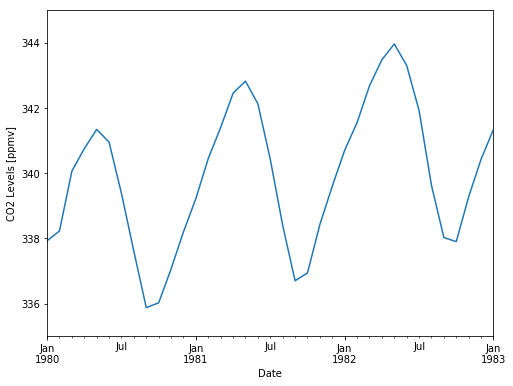

In [12]:
ax = df_co2.plot(figsize=(8, 6))
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels [ppmv]')
plt.xlim(['1980-01-01','1983-01-01'])
plt.ylim([335,345])
plt.show()

To learn more about time series pre-processing, please refer to “A Guide to Time Series Visualization with Python 3,” where the steps above are described in more detail. See https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3

Now that we’ve converted and explored our data, let’s move on to time series forecasting with ARIMA.

## Step 4:  The ARIMA Time Series Model
One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

There are three distinct integers (`p`, `d`, `q`) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation `ARIMA(p, d, q)`. Together these three parameters account for seasonality, trend, and noise in datasets:

* `p` is the *auto-regressive* part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
* `d` is the *integrated* part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
* `q` is the *moving average* part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

When dealing with seasonal effects, we make use of the *seasonal* ARIMA, which is denoted as `ARIMA(p,d,q)(P,D,Q)s`. Here, `(p, d, q)` are the non-seasonal parameters described above, while `(P, D, Q)` follow the same definition but are applied to the seasonal component of the time series. The term `s` is the periodicity of the time series (`4` for quarterly periods, `12` for yearly periods, etc.).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved. In the next section, we will describe how to automate the process of identifying the optimal set of parameters for the seasonal ARIMA time series model.

## Step 5: Parameter Selection for the ARIMA Time Series Model
When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of `ARIMA(p,d,q)(P,D,Q)s` that optimize a metric of interest. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. Other statistical programming languages such as `R` provide automated ways to solve this issue (https://www.rdocumentation.org/packages/forecast/versions/7.3/topics/auto.arima), but those have yet to be ported over to Python. In this section, we will resolve this issue by writing Python code to programmatically select the optimal parameter values for our `ARIMA(p,d,q)(P,D,Q)s` time series model.

We will use a “grid search” to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the `SARIMAX()` function from the `statsmodels` module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let’s begin by generating the various combination of parameters that we wish to assess:

In [13]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


We can now use the triplets of parameters defined above to automate the process of training and evaluating ARIMA models on different combinations. In Statistics and Machine Learning, this process is known as grid search (or hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the `AIC` (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using `statsmodels`. The `AIC` measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest `AIC` value.

The code chunk below iterates through combinations of parameters and uses the `SARIMAX` function from `statsmodels` to fit the corresponding Seasonal ARIMA model. Here, the `order` argument specifies the `(p, d, q)` parameters, while the `seasonal_order` argument specifies the `(P, D, Q, S)` seasonal component of the Seasonal ARIMA model. After fitting each `SARIMAX()` model, the code prints out its respective `AIC` score.

Because some parameter combinations may lead to numerical misspecifications, we explicitly disabled warning messages in order to avoid an overload of warning messages. These misspecifications can also lead to errors and throw an exception, so we make sure to catch these exceptions and ignore the parameter combinations that cause these issues.

The code below may take some time.

In [14]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_co2,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624036737
SARIMAX(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727641156
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320035
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878498284585
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647913337166
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754098349
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327360112
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067312878
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.41747167922
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1084.8212083725516
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC:780.4319753278725
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893617642
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988550679
SARIMAX(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
SARIMAX(0, 1, 0)x(0, 0,

The output of our code suggests that `SARIMAX(1, 1, 1)x(1, 1, 1, 12)` yields the lowest `AIC` value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

## Step 6: Fitting an ARIMA Time Series Model
Using grid search, we have identified the set of parameters that produces the best fitting model to our time series data. We can proceed to analyze this particular model in more depth.

We’ll start by plugging the optimal parameter values into a new `SARIMAX` model:

In [15]:
mod = sm.tsa.statespace.SARIMAX(df_co2,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.446      0.001       0.137       0.499
ma.L1         -0.6257      0.076     -8.181      0.000      -0.776      -0.476
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8767      0.026    -33.787      0.000      -0.928      -0.826
sigma2         0.0971      0.004     22.636      0.000       0.089       0.106


The `summary` attribute that results from the output of `SARIMAX` returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The `coef` column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The `P>|z|` column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to `0.05`, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The `plot_diagnostics` object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

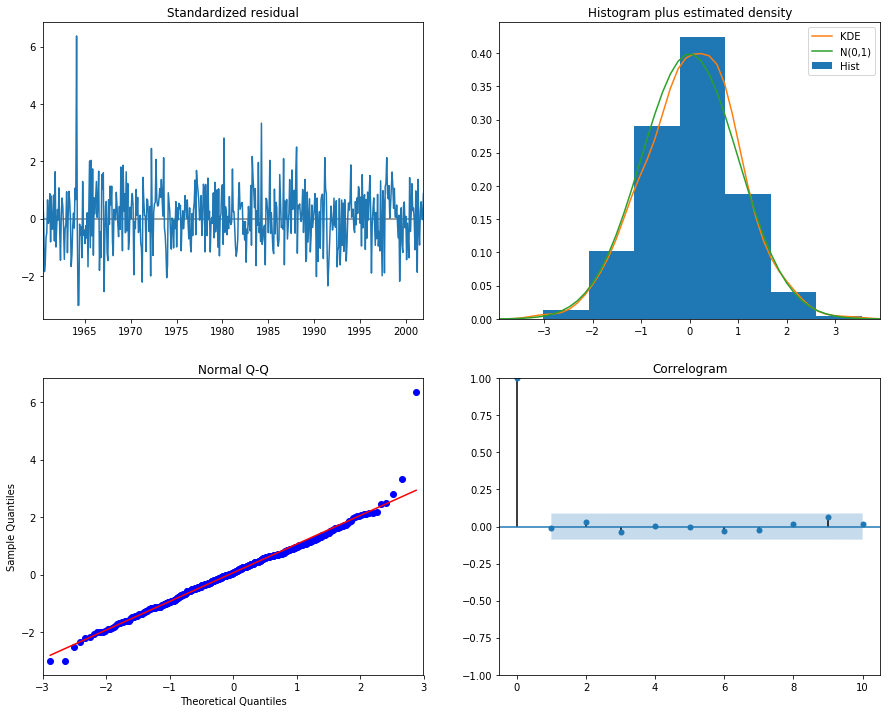

In [16]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

* In the top right plot, we see that the red `KDE` line follows closely with the `N(0,1)` line (where `N(0,1)`) is the standard notation for a normal distribution with mean `0` and standard deviation of `1`). This is a good indication that the residuals are normally distributed.
* The `qq-plot` on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with `N(0, 1)`. Again, this is a strong indication that the residuals are normally distributed.
* The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

## Step 7: Validating Forecasts
We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The `get_prediction()` and `conf_int()` attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [17]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

The code above requires the forecasts to start at January 1998.

The `dynamic=False` argument ensures that we produce one-step ahead forecasts, meaning that forecasts at each point are generated using the full history up to that point.

We can plot the real and forecasted values of the CO<sub>2</sub> time series to assess how well we did. Notice how we zoomed in on the end of the time series by slicing the date index.

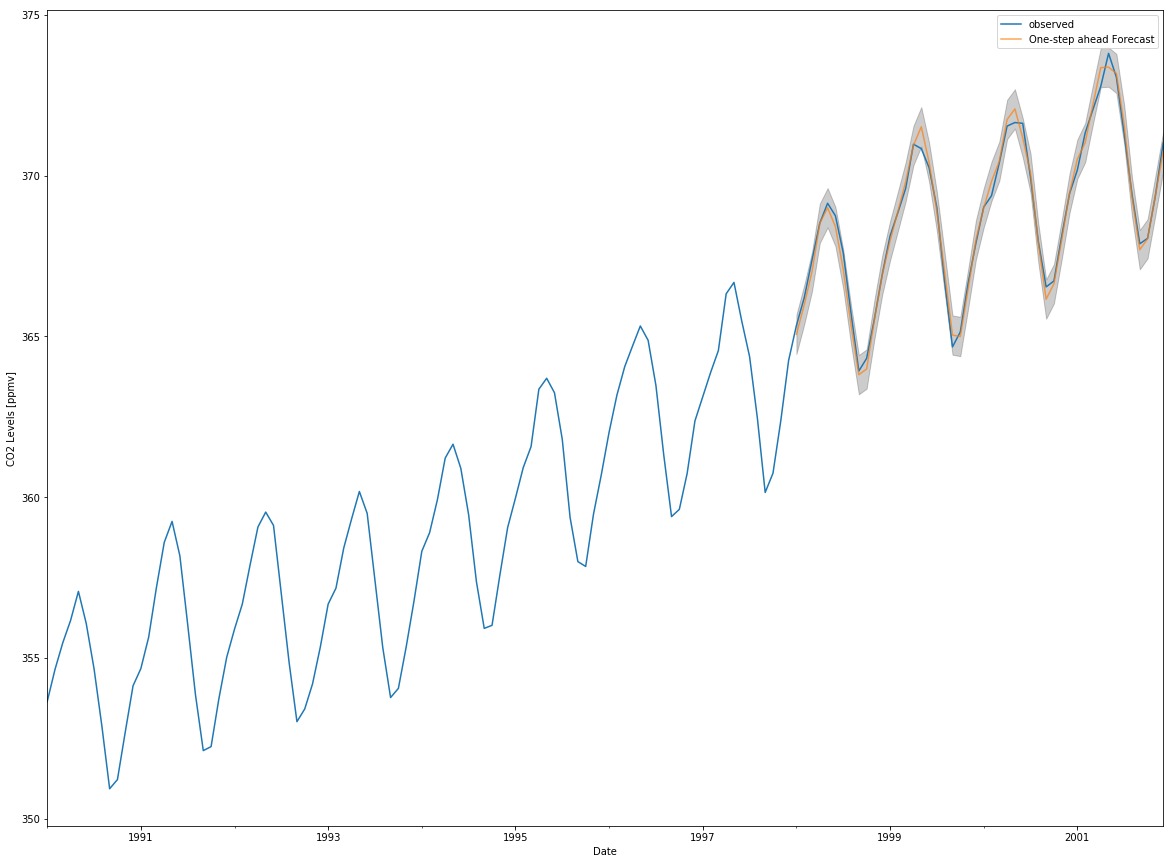

In [18]:
ax = df_co2['1990':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels [ppmv]')
plt.legend()

plt.show()

Overall, our forecasts align with the true values very well, showing an overall increase trend.

It is also useful to quantify the accuracy of our forecasts. We will use the MSE (Mean Squared Error), which summarizes the average error of our forecasts. For each predicted value, we compute its distance to the true value and square the result. The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [19]:
co2_forecasted = pred.predicted_mean
co2_truth = df_co2['1998-01-01':]

# Compute the mean square error
mse = ((co2_forecasted - co2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


The MSE of our one-step ahead forecasts yields a value of `0.07`, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.

However, a better representation of our true predictive power can be obtained using dynamic forecasts. In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points.

In the code chunk below, we specify to start computing the dynamic forecasts and confidence intervals from January 1998 onwards.

In [20]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

Plotting the observed and forecasted values of the time series, we see that the overall forecasts are accurate even when using dynamic forecasts. All forecasted values (red line) match pretty closely to the ground truth (blue line), and are well within the confidence intervals of our forecast.

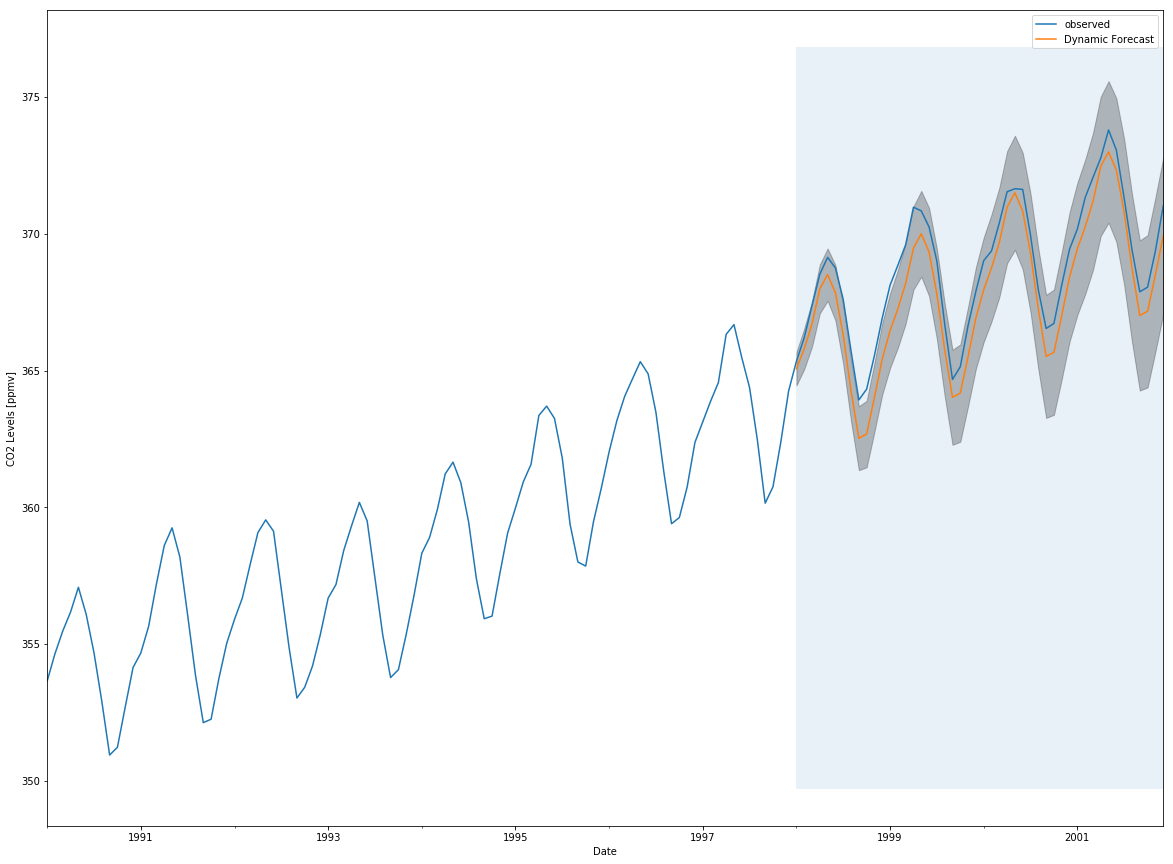

In [21]:
ax = df_co2['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), df_co2.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels [ppmv]')

plt.legend()
plt.show()

Once again, we quantify the predictive performance of our forecasts by computing the MSE:

In [22]:
# Extract the predicted and true values of our time series
co2_forecasted = pred_dynamic.predicted_mean
co2_truth = df_co2['1998-01-01':]

# Compute the mean square error
mse = ((co2_forecasted - co2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


The predicted values obtained from the dynamic forecasts yield an MSE of 1.01. This is slightly higher than the one-step ahead, which is to be expected given that we are relying on less historical data from the time series.

Both the one-step ahead and dynamic forecasts confirm that this time series model is valid. However, much of the interest around time series forecasting is the ability to forecast future values way ahead in time.

## Step 8: Producing and Visualizing Forecasts
In the final step of this tutorial, we describe how to leverage our seasonal ARIMA time series model to forecast future values. The `get_forecast()` attribute of our time series object can compute forecasted values for a specified number of steps ahead.

In [23]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

We can use the output of this code to plot the time series and forecasts of its future values.

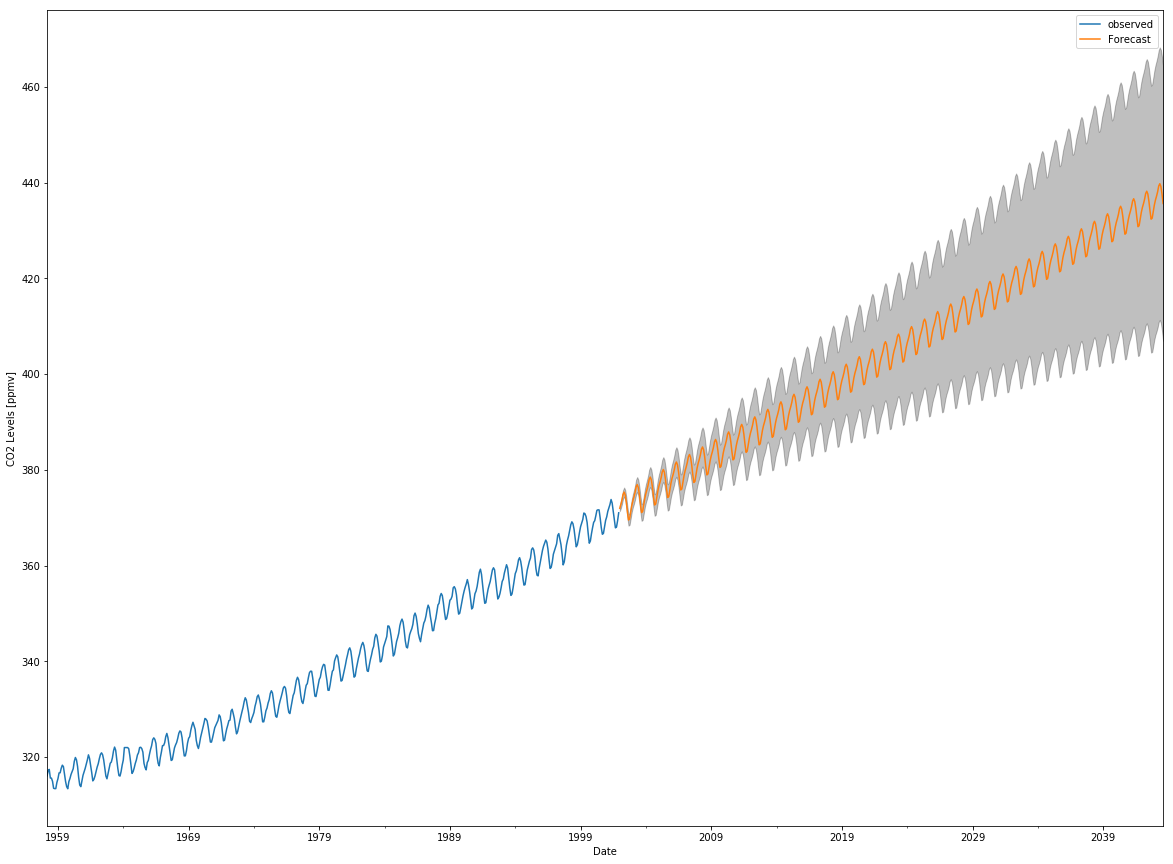

In [24]:
ax = df_co2.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels [ppmv]')

plt.legend()
plt.show()

Both the forecasts and associated confidence interval that we have generated can now be used to further understand the time series and foresee what to expect. Our forecasts show that the time series is expected to continue increasing at a steady pace.

As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

## Conclusion
In this tutorial, we described how to implement a seasonal ARIMA model in Python. We made extensive use of the pandas and statsmodels libraries and showed how to run model diagnostics, as well as how to produce forecasts of the CO<sub>2</sub> time series.

Here are a few other things you could try:

* Change the start date of your dynamic forecasts to see how this affects the overall quality of your forecasts.
* Try more combinations of parameters to see if you can improve the goodness-of-fit of your model.
* Select a different metric to select the best model. For example, we used the `AIC` measure to find the best model, but you could seek to optimize the out-of-sample mean square error instead.

For more practice, you could also try to load another time series dataset to produce your own forecasts.